$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=10
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global num_action
num_action=8

global obs_para
obs_para=6

global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.2**(N-i))
print(coeff)

C:\Users\ChangWeiYueh\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[1.1258999068426271e-35, 5.629499534213136e-35, 2.8147497671065676e-34, 1.4073748835532837e-33, 7.036874417766418e-33, 3.5184372088832087e-32, 1.7592186044416043e-31, 8.796093022208022e-31, 4.39804651110401e-30, 2.199023255552005e-29, 1.0995116277760024e-28, 5.497558138880012e-28, 2.7487790694400056e-27, 1.374389534720003e-26, 6.871947673600013e-26, 3.4359738368000065e-25, 1.717986918400003e-24, 8.589934592000015e-24, 4.294967296000008e-23, 2.1474836480000035e-22, 1.0737418240000018e-21, 5.368709120000009e-21, 2.684354560000004e-20, 1.342177280000002e-19, 6.71088640000001e-19, 3.3554432000000048e-18, 1.6777216000000023e-17, 8.388608000000011e-17, 4.194304000000005e-16, 2.0971520000000026e-15, 1.0485760000000012e-14, 5.2428800000000056e-14, 2.6214400000000027e-13, 1.3107200000000013e-12, 6.5536000000000055e-12, 3.276800000000003e-11, 1.6384000000000013e-10, 8.192000000000005e-10, 4.096000000000002e-09, 2.0480000000000012e-08, 1.0240000000000006e-07, 5.120000000000002e-07, 2.560000000000

In [2]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [3]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(10-np.sqrt((obs[0]-target[0])**2+(obs[1]-target[1])**2)-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [4]:
global lr
lr=0.01
global eps
eps=0.05
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/2],[-1,np.pi/2],[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4],[1,-np.pi/2],[-1,-np.pi/2]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(num_action)
    else:
        result=[]
        for i in range(num_action):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(num_action):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(num_action)]
history_r=[0 for i in range(num_action)]
history_su_next=[0 for i in range(num_action)]
flags=[True for i in range(num_action)]

history_rt=[[[] for i in range(num_action)] for j in range(N+1)]
history_sut=[[[] for i in range(num_action)] for j in range(N+1)]
flags_t=[[True for i in range(num_action)] for j in range(N+1)]

# Simulation


In [5]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(num_action)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(num_action)]
    
    '''
    coeff=[]
    for i in range(N):
        coeff.append((np.random.random()-0.5)/100+0.8**(N-i))
    coeff.append(1)
    #print(coeff)
    '''
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(num_action):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(num_action):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(num_action):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:01<01:34,  1.20s/it]

observation = [-2.88783271e+00 -2.25301279e+00 -6.28318531e-01  3.14473514e-04
  2.04294672e-02  3.99718978e-02]


  2%|██                                                                                 | 2/80 [00:02<01:42,  1.31s/it]

observation = [-3.03094022e+00 -3.40852883e+00  2.82743339e+00  1.76288159e-04
  6.80344916e-03  9.99297446e-03]


  4%|███                                                                                | 3/80 [00:03<01:44,  1.35s/it]

observation = [-2.42786498 -2.55178605 -1.72787596  0.0091309   0.00756101  0.02593855]


  5%|████▏                                                                              | 4/80 [00:05<01:47,  1.41s/it]

observation = [-4.73558188 -1.89139198 -2.51327412  0.01034146  0.05306382  0.01776529]


  6%|█████▏                                                                             | 5/80 [00:07<01:51,  1.49s/it]

observation = [-3.24552868 -1.78885322  2.82743339  0.00571213  0.00749352  0.00999297]


  8%|██████▏                                                                            | 6/80 [00:08<01:59,  1.62s/it]

observation = [-1.91758215e+00 -1.55287027e+00  7.85398163e-01  6.48408748e-04
  1.55028557e-04  7.71062844e-04]


  9%|███████▎                                                                           | 7/80 [00:10<02:06,  1.73s/it]

observation = [-8.63537868e-01 -1.08455234e+00  9.02056208e-17  5.03873811e-04
  3.64603042e-03  8.23599867e-31]


 10%|████████▎                                                                          | 8/80 [00:12<02:00,  1.68s/it]

observation = [-1.20532847  2.35152269 -1.41371669  0.03010332  0.04244626  0.00249824]


 11%|█████████▎                                                                         | 9/80 [00:14<02:09,  1.82s/it]

observation = [-1.63706697  2.1234656  -1.57079633  0.03378066  0.03768629  0.00308425]


 12%|██████████▎                                                                       | 10/80 [00:17<02:27,  2.11s/it]

observation = [-1.72279122e+00  2.32543224e+00 -1.09955743e+00  1.89033557e-02
  5.70770245e-02  1.51128317e-03]


 14%|███████████▎                                                                      | 11/80 [00:20<02:40,  2.32s/it]

observation = [-1.83033568e+00  2.75289693e+00 -9.42477796e-01  2.30937311e-02
  6.83098702e-02  1.11033050e-03]


 15%|████████████▎                                                                     | 12/80 [00:23<02:51,  2.53s/it]

observation = [-1.15270844e+00  2.56722499e+00 -9.42477796e-01  3.47803134e-02
  5.37768584e-02  1.11033050e-03]


 16%|█████████████▎                                                                    | 13/80 [00:26<03:00,  2.69s/it]

observation = [-9.75467335e-01  2.21995593e+00 -9.42477796e-01  3.20517004e-02
  4.55279670e-02  1.11033050e-03]


 18%|██████████████▎                                                                   | 14/80 [00:29<03:12,  2.91s/it]

observation = [-0.72271095  0.22806764 -1.25663706  0.00749939  0.01670238  0.00197392]


 19%|███████████████▍                                                                  | 15/80 [00:33<03:20,  3.08s/it]

observation = [ 2.46314869e-02 -1.15487151e+00 -7.85398163e-01  3.54935488e-03
  2.86704098e-03  7.71062844e-04]


 20%|████████████████▍                                                                 | 16/80 [00:36<03:29,  3.28s/it]

observation = [-0.36270189 -0.42815582 -1.09955743  0.00524531  0.00907358  0.00151128]


 21%|█████████████████▍                                                                | 17/80 [00:40<03:40,  3.49s/it]

observation = [-4.93700526e-01  3.24173163e+00 -1.41371669e+00  4.90618701e-02
  6.63636735e-02  2.49824361e-03]


 22%|██████████████████▍                                                               | 18/80 [00:45<03:54,  3.78s/it]

observation = [-9.95674378e-01  2.16304757e+00 -7.85398163e-01  1.80597439e-02
  5.63510764e-02  7.71062844e-04]


 24%|███████████████████▍                                                              | 19/80 [00:50<04:06,  4.05s/it]

observation = [-1.10065355e+00  1.24529507e+00 -6.28318531e-01  5.79486890e-03
  3.90666013e-02  4.93480220e-04]


 25%|████████████████████▌                                                             | 20/80 [00:55<04:20,  4.34s/it]

observation = [-0.3769285   0.50468005 -1.09955743  0.00893356  0.02114366  0.00151128]


 26%|█████████████████████▌                                                            | 21/80 [01:00<04:31,  4.60s/it]

observation = [ 4.19495039e-02  4.58736750e-01 -3.14159265e-01  7.44680386e-03
  2.13585722e-02  1.23370055e-04]


 28%|██████████████████████▌                                                           | 22/80 [01:05<04:33,  4.72s/it]

observation = [ 0.37185295  0.0646449  -1.09955743  0.00858175  0.01534217  0.00151128]


 29%|███████████████████████▌                                                          | 23/80 [01:10<04:46,  5.03s/it]

observation = [ 0.47839724  0.13581319 -0.9424778   0.01050348  0.01565732  0.00111033]


 30%|████████████████████████▌                                                         | 24/80 [01:17<05:03,  5.42s/it]

observation = [ 0.36026586  0.42764671 -1.09955743  0.01357914  0.02036102  0.00151128]


 31%|█████████████████████████▋                                                        | 25/80 [01:24<05:27,  5.96s/it]

observation = [ 5.35056373e-01  9.58751995e-02 -7.85398163e-01  1.16516539e-02
  1.51113714e-02  7.71062844e-04]


 32%|██████████████████████████▋                                                       | 26/80 [01:31<05:40,  6.31s/it]

observation = [ 0.3393722   0.90006869 -1.41371669  0.01848217  0.02580437  0.00249824]


 34%|███████████████████████████▋                                                      | 27/80 [01:39<05:57,  6.75s/it]

observation = [ 0.49710508  0.1476257  -0.9424778   0.01116181  0.01679941  0.00111033]


 35%|████████████████████████████▋                                                     | 28/80 [01:47<06:12,  7.17s/it]

observation = [ 0.96840314 -0.13084242 -0.9424778   0.01038816  0.01418678  0.00111033]


 36%|█████████████████████████████▋                                                    | 29/80 [01:55<06:23,  7.52s/it]

observation = [ 1.29015652e+00 -1.96714448e-01 -9.42477796e-01  1.15923425e-02
  1.30135230e-02  1.11033050e-03]


 38%|██████████████████████████████▊                                                   | 30/80 [02:04<06:37,  7.95s/it]

observation = [ 1.13254113e+00 -2.97826202e-01 -7.85398163e-01  8.54121836e-03
  1.26823934e-02  7.71062844e-04]


 39%|███████████████████████████████▊                                                  | 31/80 [02:14<06:48,  8.34s/it]

observation = [ 1.04794457  0.29716826 -0.9424778   0.01207284  0.02148158  0.00111033]


 40%|████████████████████████████████▊                                                 | 32/80 [02:24<07:03,  8.81s/it]

observation = [ 1.17519593e+00 -1.29335370e-01 -9.42477796e-01  9.35566601e-03
  1.47694130e-02  1.11033050e-03]


 41%|█████████████████████████████████▊                                                | 33/80 [02:34<07:18,  9.34s/it]

observation = [ 1.20521472e+00  7.50800181e-02 -9.42477796e-01  9.92201722e-03
  1.80910730e-02  1.11033050e-03]


 42%|██████████████████████████████████▊                                               | 34/80 [02:44<07:23,  9.64s/it]

observation = [ 1.76018250e+00 -5.46571635e-01 -4.71238898e-01  1.06569645e-02
  8.99118263e-03  2.77582624e-04]


 44%|███████████████████████████████████▉                                              | 35/80 [02:54<07:14,  9.66s/it]

observation = [ 1.15975592e+00  1.81134162e-01 -9.42477796e-01  8.94142229e-03
  1.90344904e-02  1.11033050e-03]


 45%|████████████████████████████████████▉                                             | 36/80 [03:04<07:13,  9.84s/it]

observation = [ 1.12307411e+00  6.36279869e-02 -7.85398163e-01  8.30068072e-03
  1.70759695e-02  7.71062844e-04]


 46%|█████████████████████████████████████▉                                            | 37/80 [03:15<07:12, 10.07s/it]

observation = [ 2.06888639e+00 -6.63771851e-01 -3.14159265e-01  1.16513555e-02
  7.38769615e-03  1.23370055e-04]


 48%|██████████████████████████████████████▉                                           | 38/80 [03:26<07:18, 10.44s/it]

observation = [ 1.18525025e+00  2.55356626e-01 -9.42477796e-01  9.45187287e-03
  2.04208137e-02  1.11033050e-03]


 49%|███████████████████████████████████████▉                                          | 39/80 [03:38<07:20, 10.75s/it]

observation = [ 1.16358078e+00  2.30333173e-01 -6.28318531e-01  9.04493289e-03
  2.00984412e-02  4.93480220e-04]


 50%|█████████████████████████████████████████                                         | 40/80 [03:50<07:25, 11.13s/it]

observation = [ 1.03559383e+00  1.36129393e-01 -4.71238898e-01  6.85226505e-03
  1.93648589e-02  2.77582624e-04]


 51%|██████████████████████████████████████████                                        | 41/80 [04:02<07:29, 11.53s/it]

observation = [ 1.48900782e+00  4.23029391e-01 -9.42477796e-01  1.03910226e-02
  2.47415154e-02  1.11033050e-03]


 52%|███████████████████████████████████████████                                       | 42/80 [04:15<07:32, 11.92s/it]

observation = [ 1.42322789e+00  3.56063898e-01 -6.28318531e-01  9.03151884e-03
  2.32595512e-02  4.93480220e-04]


 54%|████████████████████████████████████████████                                      | 43/80 [04:28<07:33, 12.25s/it]

observation = [ 2.05815481e+00 -1.67811071e-01 -4.71238898e-01  1.14213263e-02
  1.44350626e-02  2.77582624e-04]


 55%|█████████████████████████████████████████████                                     | 44/80 [04:42<07:34, 12.64s/it]

observation = [ 1.47642432e+00  4.19131782e-01 -7.85398163e-01  1.01691736e-02
  2.51274277e-02  7.71062844e-04]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [04:56<07:43, 13.24s/it]

observation = [ 1.79822690e+00  3.47231985e-01 -7.85398163e-01  1.14843465e-02
  2.38121464e-02  7.71062844e-04]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [05:12<07:50, 13.84s/it]

observation = [ 2.08501239e+00  5.17369935e-02 -6.28318531e-01  1.20278314e-02
  1.83007895e-02  4.93480220e-04]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [05:27<07:55, 14.40s/it]

observation = [ 1.31972474  1.90602667 -1.25663706  0.017805    0.05635037  0.00197392]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [05:43<07:57, 14.91s/it]

observation = [ 1.98665795e+00  2.93496335e-01 -1.57079633e-01  9.88632610e-03
  2.31730609e-02  3.08425138e-05]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [05:58<07:40, 14.85s/it]

observation = [ 2.18844358e+00  3.66536181e-01 -4.71238898e-01  8.83430175e-03
  2.30345848e-02  2.77582624e-04]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [06:14<07:34, 15.16s/it]

observation = [ 2.33829646e+00  3.78569399e-01 -4.71238898e-01  1.17915031e-02
  2.47017011e-02  2.77582624e-04]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [06:31<07:37, 15.78s/it]

observation = [ 2.01525460e+00  1.51082990e+00 -1.25663706e+00  1.02839806e-02
  4.88585843e-02  1.97392088e-03]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [06:49<07:41, 16.47s/it]

observation = [ 2.18531537e+00  1.27840165e+00 -1.25663706e+00  8.61094013e-03
  4.57901879e-02  1.97392088e-03]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [07:08<07:43, 17.16s/it]

observation = [ 1.04609568e+00  3.62902785e+00 -1.41371669e+00  3.90149686e-02
  8.93528868e-02  2.49824361e-03]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [07:28<07:46, 17.95s/it]

observation = [ 2.87798524e+00  5.91578830e-01 -1.57079633e-01  1.21947817e-02
  2.81194003e-02  3.08425138e-05]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [07:48<07:45, 18.61s/it]

observation = [ 2.87900321e+00  7.31334070e-01 -3.14159265e-01  1.20973966e-02
  3.22632751e-02  1.23370055e-04]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [08:09<07:43, 19.30s/it]

observation = [ 2.94771170e+00  9.62011457e-01 -3.14159265e-01  1.37241873e-02
  3.80693995e-02  1.23370055e-04]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [08:30<07:37, 19.89s/it]

observation = [ 2.84149427e+00  9.11201884e-01 -4.71238898e-01  1.13194184e-02
  3.63156175e-02  2.77582624e-04]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [08:52<07:30, 20.46s/it]

observation = [ 2.89272453e+00  8.32284800e-01 -1.57079633e-01  1.24523218e-02
  3.46115633e-02  3.08425138e-05]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [09:15<07:25, 21.22s/it]

observation = [ 2.84207218e+00  1.08189454e+00 -5.41233725e-17  1.13319911e-02
  4.10350602e-02  2.47293546e-30]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [09:38<07:15, 21.79s/it]

observation = [3.26627227e+00 8.78892464e-01 1.57079633e-01 1.51784801e-02
 3.55190101e-02 3.08425138e-05]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [10:02<07:03, 22.30s/it]

observation = [ 2.79967111e+00  1.30516957e+00 -2.77555756e-18  1.03945801e-02
  4.73753136e-02  4.76368372e-30]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [10:26<06:55, 23.09s/it]

observation = [ 2.78070080e+00  1.35693138e+00 -4.71238898e-01  1.00006480e-02
  4.89856544e-02  2.77582624e-04]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [10:51<06:40, 23.58s/it]

observation = [ 2.93080852e+00  1.71680985e+00 -2.98372438e-16  7.83905448e-03
  5.88748436e-02  8.08481798e-30]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [11:15<06:16, 23.55s/it]

observation = [3.00368789e+00 1.56335223e+00 6.28318531e-01 9.25771631e-03
 5.41832470e-02 4.93480220e-04]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [11:41<06:05, 24.37s/it]

observation = [2.89468347e+00 1.69573150e+00 4.71238898e-01 7.24276688e-03
 5.75349171e-02 2.77582624e-04]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [12:07<05:50, 25.01s/it]

observation = [3.01152774e+00 1.51123877e+00 4.71238898e-01 9.39529162e-03
 5.25567404e-02 2.77582624e-04]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [12:34<05:31, 25.50s/it]

observation = [2.92492767e+00 1.53303871e+00 3.14159265e-01 7.89114659e-03
 5.18026375e-02 1.23370055e-04]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [13:02<05:13, 26.08s/it]

observation = [ 2.72694048e+00  9.52263422e-01 -2.42861287e-16  5.08461892e-03
  3.17890795e-02  1.04831400e-29]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [13:30<04:55, 26.86s/it]

observation = [3.03140577e+00 1.47609028e+00 4.71238898e-01 9.78931967e-03
 5.15995612e-02 2.77582624e-04]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [13:59<04:33, 27.34s/it]

observation = [2.89910208e+00 1.60533714e+00 1.57079633e-01 7.42077163e-03
 5.39990333e-02 3.08425138e-05]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [14:29<04:14, 28.22s/it]

observation = [2.87424064e+00 1.76363257e+00 4.71238898e-01 6.85365421e-03
 5.98955040e-02 2.77582624e-04]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [15:00<03:52, 29.06s/it]

observation = [3.18853658e+00 1.95224028e+00 7.85398163e-01 7.82545719e-03
 6.55219391e-02 7.71062844e-04]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [15:33<03:31, 30.19s/it]

observation = [3.20219413e+00 1.98505969e+00 6.28318531e-01 8.01057643e-03
 6.72239081e-02 4.93480220e-04]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [16:05<03:05, 30.86s/it]

observation = [3.26792537e+00 1.88501439e+00 7.85398163e-01 9.23847318e-03
 6.43264681e-02 7.71062844e-04]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [16:39<02:38, 31.78s/it]

observation = [3.19883149e+00 1.98775229e+00 7.85398163e-01 7.95612428e-03
 6.72558247e-02 7.71062844e-04]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [17:13<02:09, 32.34s/it]

observation = [3.13806659e+00 2.05108206e+00 9.42477796e-01 6.91433614e-03
 6.87711462e-02 1.11033050e-03]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [17:47<01:38, 32.81s/it]

observation = [2.74438645e+00 1.88422068e+00 4.71238898e-01 4.93543261e-03
 6.22004980e-02 2.77582624e-04]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [18:22<01:07, 33.55s/it]

observation = [2.42480424e+00 2.19064275e+00 1.41371669e+00 1.53654702e-03
 6.86233168e-02 2.49824361e-03]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [19:01<00:35, 35.28s/it]

observation = [2.56564867e+00 2.07221431e+00 7.85398163e-01 2.78311594e-03
 6.64762425e-02 7.71062844e-04]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [19:38<00:00, 14.73s/it]

observation = [2.86391378e+00 1.78600256e+00 7.85398163e-01 6.68148937e-03
 6.05793793e-02 7.71062844e-04]


# Results

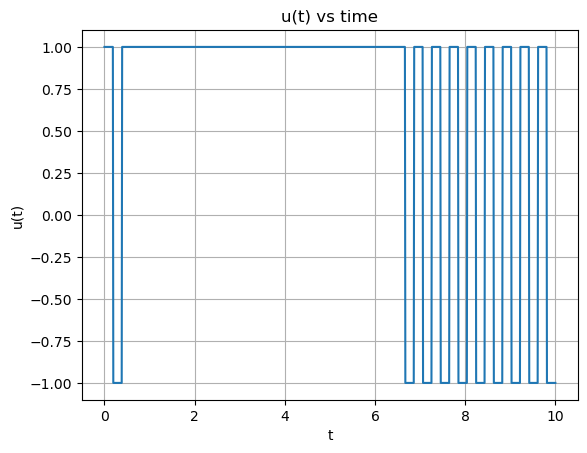

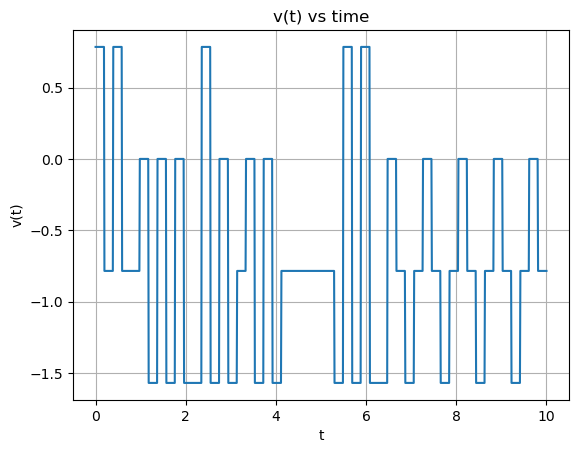

In [6]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


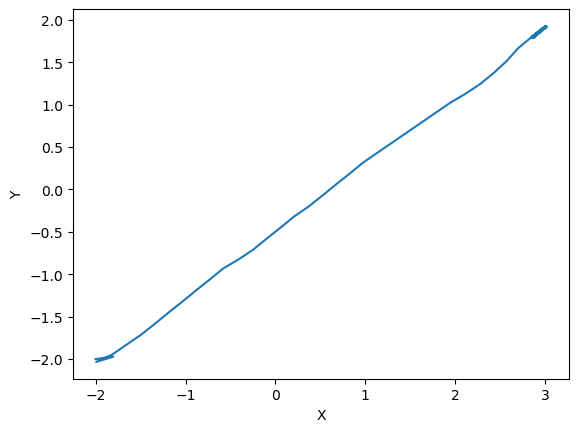

In [7]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

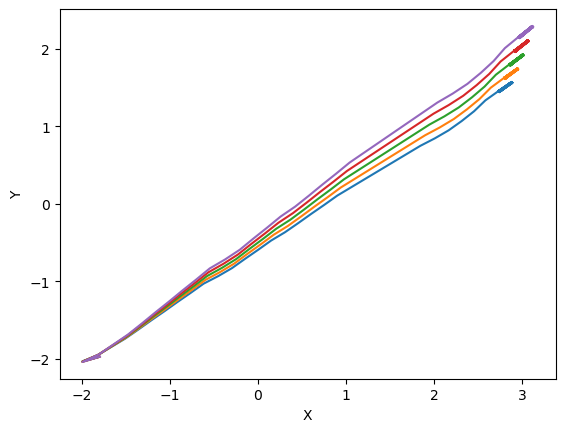

1.5285345584996242


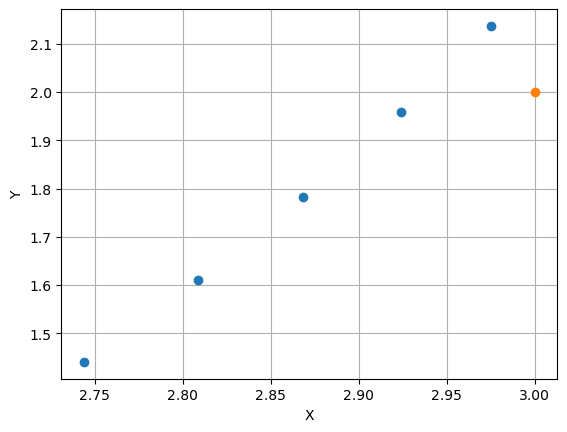

In [8]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

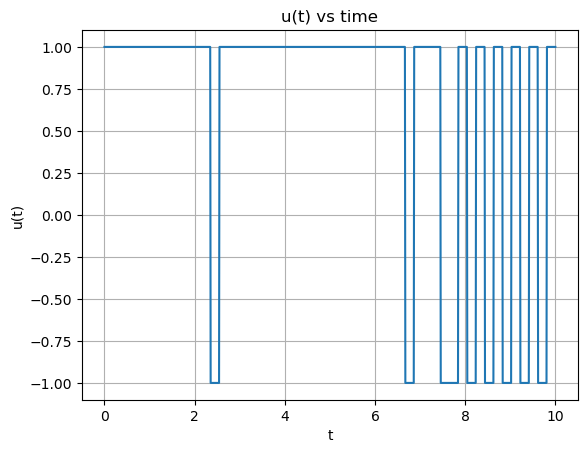

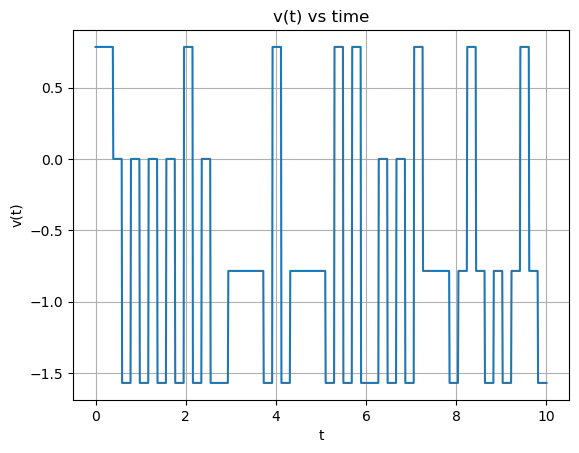

In [9]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

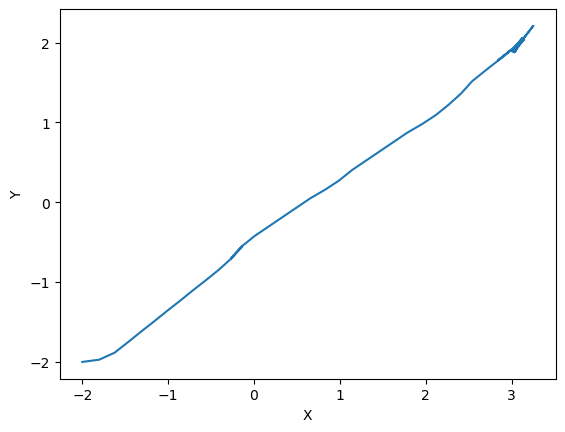

In [10]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

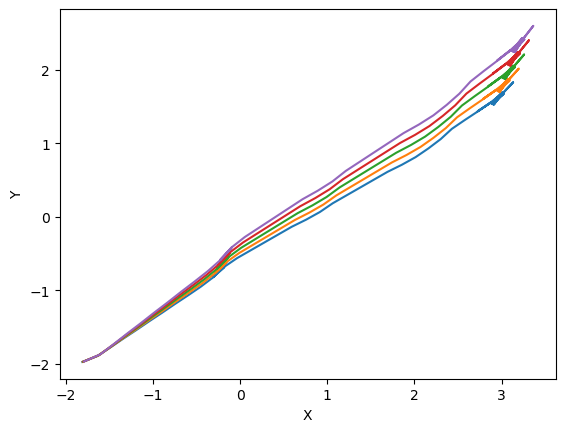

1.428057706957864


In [11]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

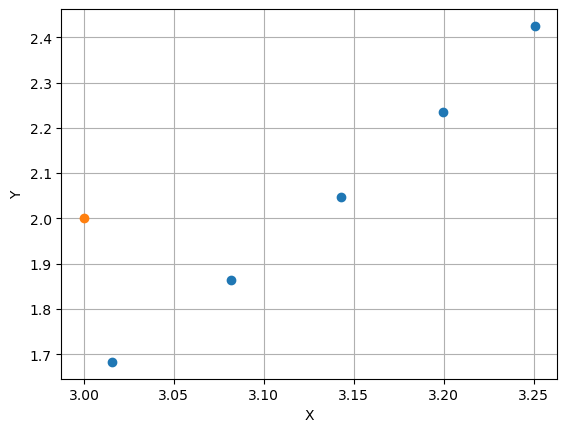

In [12]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

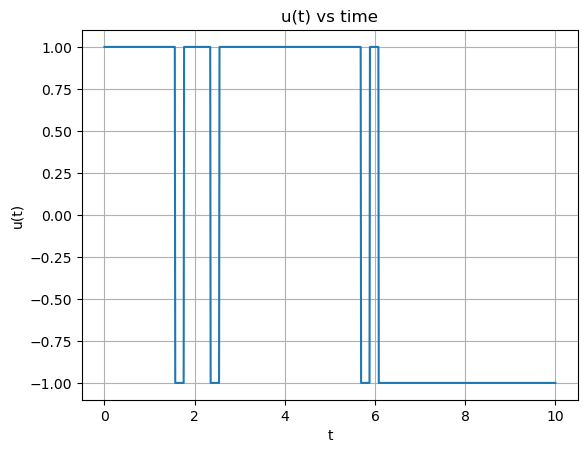

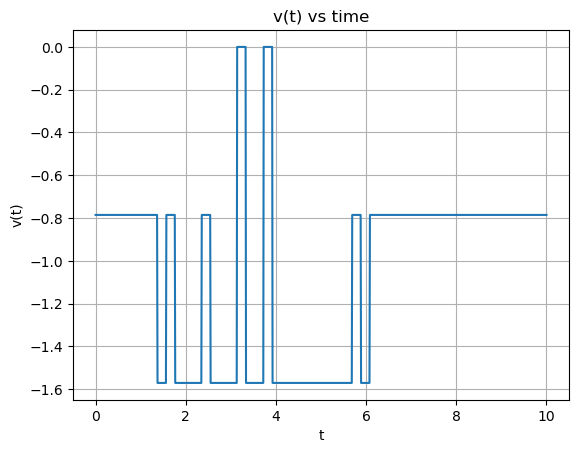

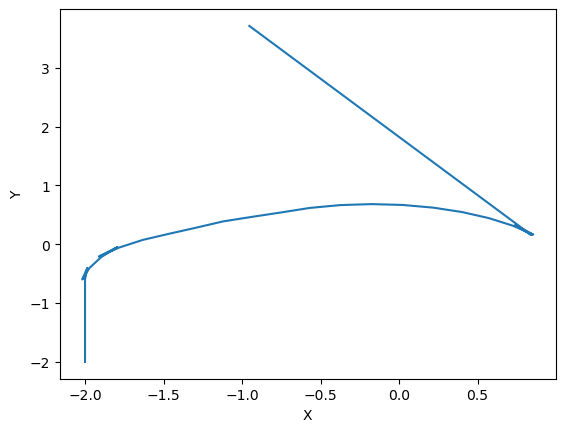

In [13]:
position=np.array([[-2,-2,np.pi/2] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

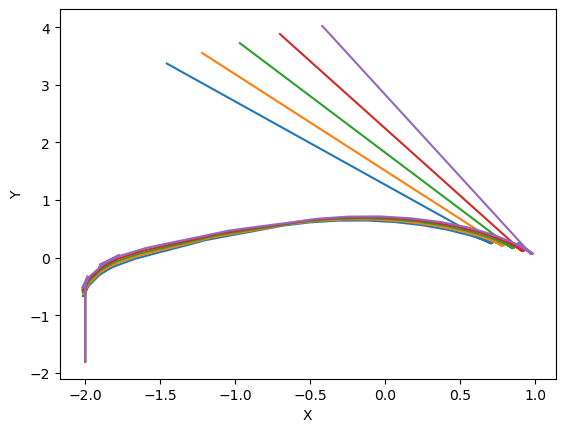

21.61520726928325


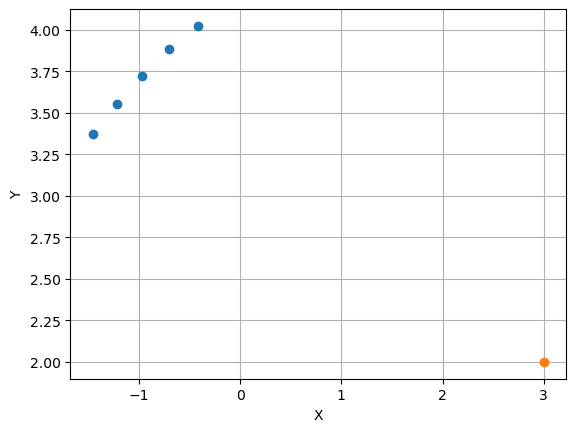

In [14]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()